# Assignment 3 - Variational Autoencoders (VAEs)

## Theory Questions:


### **Q1: Why is the KL Divergence term important in the VAE loss function?**

The **Kullback-Leibler (KL) Divergence** term in the **Variational Autoencoder (VAE)** loss function measures how much the learned latent distribution \( q(z|x) \) deviates from a prior distribution \( p(z) \) (usually a standard normal distribution). It serves several key purposes:

- **Regularization**: The KL divergence acts as a regularizer, encouraging the latent variables to follow a known, structured distribution (e.g., \( \mathcal{N}(0, I) \)). This prevents overfitting and helps the model generalize better.
  
- **Ensuring Latent Space Structure**: It forces the latent space to be continuous and smooth, which makes interpolation between points in latent space meaningful and allows for generation of new, coherent data samples.

- **Balancing Reconstruction and Regularization**: The total VAE loss consists of the reconstruction loss (how accurately the input is reconstructed) and the KL divergence (how close the latent space is to the prior). The KL term ensures that the model doesn't just memorize data but learns a meaningful representation.

---

### **Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?**

The **reparameterization trick** allows gradients to flow through stochastic layers, making **backpropagation** feasible in VAEs. Normally, sampling from a distribution (e.g., \( z \sim \mathcal{N}(\mu, \sigma^2) \)) would introduce non-differentiability. The trick restructures the sampling process to separate randomness from the deterministic parameters.

- **How it Works**: Instead of directly sampling \( z \), we express it as:
  \[
  z = \mu + \sigma \cdot \epsilon
  \]
  where \( \epsilon \sim \mathcal{N}(0, 1) \) is random noise, and \( \mu \) and \( \sigma \) are outputs from the encoder.

- **Why It Helps**: Since \( \epsilon \) is independent of \( \mu \) and \( \sigma \), gradients can now flow through \( \mu \) and \( \sigma \) during backpropagation, enabling the optimization of these parameters via standard gradient-based methods.

---

### **Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?**

A **probabilistic latent space** provides several advantages over a fixed deterministic space:

- **Uncertainty Representation**: It captures uncertainty in the data by representing each input as a distribution in the latent space, not just a single point. This is useful for tasks like generative modeling, where variability is important.

- **Better Generalization**: By encoding inputs as distributions, the model avoids overfitting to specific data points and instead learns a broader, more general representation of the data.

- **Generative Capabilities**: A probabilistic latent space allows the model to sample new data points by drawing from the latent distribution \( p(z) \). This is fundamental for generating diverse and coherent outputs.

- **Smooth Interpolation**: It ensures smooth transitions between points in the latent space, enabling meaningful interpolation between different data samples.

---

### **Q4: What role does KL Divergence play in ensuring a smooth latent space?**

The **KL Divergence** term in the VAE loss enforces that the learned latent distribution \( q(z|x) \) is close to the prior distribution \( p(z) \), typically a standard normal distribution \( \mathcal{N}(0, I) \). This plays a crucial role in maintaining a **smooth latent space**:

- **Prevents Disjoint Regions**: Without KL regularization, the latent space could become fragmented, leading to gaps or disjoint clusters. KL divergence ensures that similar data points are encoded into nearby regions of the latent space.

- **Encourages Continuity**: By minimizing divergence from the prior, the latent space remains continuous, allowing small changes in latent variables to result in small, gradual changes in the output. This continuity is key for interpolation and generating new samples.

- **Ensures Coverage**: It encourages the latent space to cover the entire prior distribution, preventing the model from collapsing to a few specific latent codes and ensuring diverse generation of new data.

---


### Installing the libraries
The command installs `torch` and `torchvision`, which are essential for deep learning tasks, especially in computer vision. The output shows that `torch` is already installed, while `torchvision` was installed from a cached file.

In [1]:
pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Using cached torchvision-0.21.0-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
Using cached torchvision-0.21.0-cp313-cp313-win_amd64.whl (1.6 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 2.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/8.0 MB 2.8 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.0 MB 2.8 MB/s eta 0:00:03
   ---------- ----------------------------- 2.1/8.0 MB 2.7 MB/s eta 0:00:03
   ------------- -------------------------- 2.6/8.0 MB 2.6 MB/s eta 0:00:03
   --------------- ------------------------ 3.1/8.0 MB 2.6 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.0 MB 2.7 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/8.0 MB 2.7 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.0 MB 2.7 MB/s eta 0:00:02
   --------------------------- ------------ 5.5/8.0 MB 2.7 MB/s eta 0:00:01
   ------------------------------- -----

In [9]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing necessary libraries and setting up the device
This step imports essential libraries:
- `torch` and related modules for building and optimizing neural networks.
- `torchvision` for handling image data and transformations.
- `matplotlib.pyplot` for plotting results.
- `numpy` for numerical operations.

It also sets the device to GPU (`cuda`) if available, otherwise defaults to CPU, ensuring the code runs efficiently depending on the hardware.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Fully Connected VAE Implementation
Defines the architecture of a Fully Connected Variational Autoencoder (FCVAE), which compresses and reconstructs data using neural networks.

- **Class Definition:** The `FCVAE` class inherits from `nn.Module`, making it compatible with PyTorch's neural network utilities.
  
- **Architecture:** 
  - Sets up the encoder and decoder architecture.
  - The encoder reduces the input dimension (3072) to a latent space of 128 dimensions through two fully connected layers with ReLU activations.
  - Two separate linear layers generate the mean (`fc_mu`) and log-variance (`fc_logvar`) for the latent space.
  - The decoder reconstructs the original input from the latent space, using fully connected layers with ReLU activations, followed by a Sigmoid function to scale the output between 0 and 1.


In [64]:
class FCVAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=400, latent_dim=128):
        super(FCVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten input image
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        # x shape: [B, C, H, W] -> [B, C*H*W]
        x = x.view(x.size(0), -1)
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z):
        # z shape: [B, latent_dim] -> [B, C, H, W]
        h3 = self.decoder(z)
        return h3.view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Step 4: Convolutional VAE Implementation
This step defines the architecture of a Convolutional Variational Autoencoder (ConvVAE), which processes image data through convolutional and transposed convolutional layers.

- **Encoder Layers:** 
  - The encoder consists of four convolutional (`Conv2d`) layers.
  - The first layer takes a 3-channel (RGB) image and outputs 32 feature maps with a kernel size of 4, stride of 2, and padding of 1, reducing the image size from 32x32 to 16x16.
  - The next layers continue this pattern, doubling the number of feature maps while halving the spatial dimensions:
    - 32 → 64 feature maps (16x16 → 8x8),
    - 64 → 128 feature maps (8x8 → 4x4),
    - 128 → 256 feature maps (4x4 → 2x2).
  - Each convolution is followed by a ReLU activation, introducing non-linearity.
  - The final output is flattened into a vector of size 256 * 2 * 2, which is fed into fully connected layers to generate the latent variables (`mu` and `logvar`).

- **Decoder Layers:** 
  - The decoder starts by projecting the latent vector back into a 256 * 2 * 2 feature map using a fully connected layer.
  - The unflattened feature map is passed through four transposed convolutional (`ConvTranspose2d`) layers that progressively upsample the data:
    - 256 → 128 feature maps (2x2 → 4x4),
    - 128 → 64 feature maps (4x4 → 8x8),
    - 64 → 32 feature maps (8x8 → 16x16),
    - 32 → 3 feature maps (16x16 → 32x32), restoring the original RGB format.
  - ReLU activations are applied after each transposed convolution, except the last layer, which uses a Sigmoid activation to ensure the output pixel values are between 0 and 1.


In [58]:
# Convolutional VAE Implementation
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [batch, 32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # [batch, 64, 8, 8]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # [batch, 128, 4, 4]
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # [batch, 256, 2, 2]
            nn.ReLU(),
            nn.Flatten()  # [batch, 256 * 2 * 2]
        )

        # Latent space
        self.fc_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(256 * 2 * 2, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 2 * 2)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 2, 2)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [batch, 128, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # [batch, 64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # [batch, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),     # [batch, 3, 32, 32]
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss Function Definition
This step defines the loss function for training the Variational Autoencoder (VAE), combining reconstruction accuracy with regularization to ensure meaningful latent representations.

- **Model Type Handling:** 
  - If the model type is `'fcvae'` (Fully Connected VAE), both the original (`x`) and reconstructed (`recon_x`) images are flattened to match dimensions for loss computation.

- **Clamping Values:** 
  - The input and reconstructed images are clamped between 0 and 1 to ensure the values remain within a valid range for binary cross-entropy loss.

- **Reconstruction Loss (BCE):** 
  - The Binary Cross-Entropy (BCE) loss measures the difference between the original and reconstructed images, assessing how well the model can reproduce the input data.

- **Kullback-Leibler Divergence (KLD):** 
  - The KL Divergence term regularizes the latent space by pushing the latent distribution towards a standard normal distribution. This ensures that the latent variables are continuous and well-structured.

- **Final Loss:** 
  - The total loss is a combination of the reconstruction loss and the KL Divergence, weighted by the `beta` parameter. This balance allows control over how much emphasis is placed on reconstruction accuracy versus latent space regularization.


In [65]:
# Loss Function Definition
def loss_function(recon_x, x, mu, logvar, model_type='cvae', beta=1.0):
    if model_type == 'fcvae':
        x = x.view(x.size(0), -1)
        recon_x = recon_x.view(x.size(0), -1)

    # Ensure values are in [0, 1]
    x = torch.clamp(x, 0, 1)
    recon_x = torch.clamp(recon_x, 0, 1)

    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

### Training Function  
This step defines the training loop for the Variational Autoencoder (VAE), where the model is set to training mode, and losses are initialized to zero for tracking progress. The `tqdm` library provides a progress bar for visualizing the training process across epochs. For each batch, data is moved to the specified device (CPU or GPU), gradients are reset, and the model generates reconstructed outputs along with latent variables (`mu` and `logvar`). The loss function calculates the total loss, reconstruction loss, and KL divergence, which are then used for backpropagation to update model weights. Gradient clipping ensures stability by preventing exploding gradients. Throughout the epoch, losses are accumulated and displayed in real-time, and the average loss is computed and printed at the end of each epoch to monitor training performance.


In [66]:

# Training Function
def train(model, train_loader, optimizer, epoch, num_epochs, model_type, device, beta=1.0):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0

    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            data = data.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            total_loss, recon_loss, kld_loss = loss_function(
                recon_batch, data, mu, logvar, model_type, beta)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()

            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )

    avg_loss = train_loss_total / len(train_loader.dataset)
    print(f'Epoch {epoch}/{num_epochs} Average loss: {avg_loss:.4f}')
    return avg_loss


### Image Generation Function  
This function generates new images from the trained VAE models by sampling random points from the latent space. The model is set to evaluation mode to disable gradient calculations, and random latent vectors are generated and decoded into images. The generated images are processed to ensure pixel values are within the valid range, and displayed using Matplotlib in a grid layout.


### Training Setup and Execution  
This step sets up the training environment, defining key hyperparameters such as batch size, number of epochs, latent dimension size, learning rate, and beta for loss balancing. The CIFAR-10 dataset is loaded, transformed into tensors, and batched for training using a data loader. Both the Fully Connected VAE (FCVAE) and Convolutional VAE (ConvVAE) models are initialized and moved to the specified device (CPU or GPU). Adam optimizers are assigned to each model with the defined learning rate, preparing the models for training.


In [61]:
# Image Generation Function
def generate_images(model, num_images=10, device="cuda"):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        samples = model.decode(z)

        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 1.5, 1.5))
        for i in range(num_images):
            img = samples[i].cpu().permute(1, 2, 0)
            img = torch.clamp(img, 0, 1)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

In [67]:
# Training Setup and Execution
# Hyperparameters
batch_size = 128
num_epochs = 10
latent_dim = 128
learning_rate = 1e-4
beta = 0.5

# Data loading
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(
    './data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# Initialize models
fcvae = FCVAE(latent_dim=latent_dim).to(device)
cvae = ConvVAE(latent_dim=latent_dim).to(device)

# Optimizers
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=learning_rate)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=learning_rate)


### Training FC-VAE and Conv-VAE Models
This step initiates the training process for both the Fully Connected VAE (FC-VAE) and the Convolutional VAE (Conv-VAE). Each model is trained for a specified number of epochs using their respective optimizers. During training, progress is tracked using a progress bar, and average losses are calculated for each epoch. Every 10 epochs, the models generate sample images to visualize how well they have learned to reconstruct data. Once training is complete, the models are saved to disk for future use.

Training FC-VAE...


Epoch 1: 100%|██████████| 391/391 [00:23<00:00, 16.77batch/s, kld_loss=13.2, recon_loss=2.04e+3, train_loss=2.05e+3]


Epoch 1/10 Average loss: 2051.1643


Epoch 2: 100%|██████████| 391/391 [00:29<00:00, 13.45batch/s, kld_loss=24.1, recon_loss=1.97e+3, train_loss=1.98e+3]


Epoch 2/10 Average loss: 1981.0409


Epoch 3: 100%|██████████| 391/391 [00:22<00:00, 17.55batch/s, kld_loss=28.1, recon_loss=1.95e+3, train_loss=1.96e+3]


Epoch 3/10 Average loss: 1960.1857


Epoch 4: 100%|██████████| 391/391 [00:23<00:00, 16.82batch/s, kld_loss=27.5, recon_loss=1.94e+3, train_loss=1.95e+3]


Epoch 4/10 Average loss: 1953.5710


Epoch 5: 100%|██████████| 391/391 [00:22<00:00, 17.25batch/s, kld_loss=26.7, recon_loss=1.93e+3, train_loss=1.95e+3]


Epoch 5/10 Average loss: 1948.0018


Epoch 6: 100%|██████████| 391/391 [00:22<00:00, 17.53batch/s, kld_loss=27.5, recon_loss=1.92e+3, train_loss=1.94e+3]


Epoch 6/10 Average loss: 1937.4126


Epoch 7: 100%|██████████| 391/391 [00:28<00:00, 13.64batch/s, kld_loss=28.4, recon_loss=1.91e+3, train_loss=1.93e+3]


Epoch 7/10 Average loss: 1925.0937


Epoch 8: 100%|██████████| 391/391 [00:24<00:00, 15.90batch/s, kld_loss=28.8, recon_loss=1.9e+3, train_loss=1.92e+3] 


Epoch 8/10 Average loss: 1916.7055


Epoch 9: 100%|██████████| 391/391 [00:22<00:00, 17.50batch/s, kld_loss=30.6, recon_loss=1.89e+3, train_loss=1.91e+3]


Epoch 9/10 Average loss: 1908.2158


Epoch 10: 100%|██████████| 391/391 [00:22<00:00, 17.16batch/s, kld_loss=31.5, recon_loss=1.88e+3, train_loss=1.9e+3] 


Epoch 10/10 Average loss: 1899.5824
Generating FC-VAE samples...


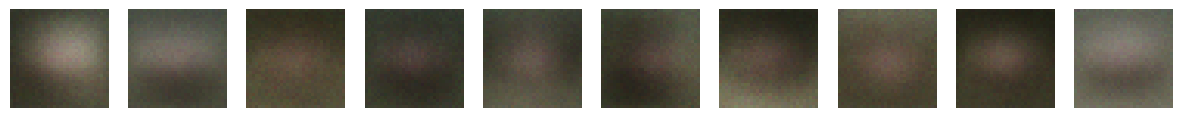


Training Conv-VAE...


Epoch 1: 100%|██████████| 391/391 [00:45<00:00,  8.65batch/s, kld_loss=16.9, recon_loss=2.03e+3, train_loss=2.04e+3]


Epoch 1/10 Average loss: 2036.4714


Epoch 2: 100%|██████████| 391/391 [00:43<00:00,  8.94batch/s, kld_loss=33.2, recon_loss=1.91e+3, train_loss=1.92e+3]


Epoch 2/10 Average loss: 1924.2241


Epoch 3: 100%|██████████| 391/391 [00:43<00:00,  8.98batch/s, kld_loss=34.4, recon_loss=1.88e+3, train_loss=1.9e+3] 


Epoch 3/10 Average loss: 1902.0228


Epoch 4: 100%|██████████| 391/391 [00:43<00:00,  9.00batch/s, kld_loss=36.3, recon_loss=1.87e+3, train_loss=1.88e+3]


Epoch 4/10 Average loss: 1884.4771


Epoch 5: 100%|██████████| 391/391 [00:43<00:00,  8.99batch/s, kld_loss=36.6, recon_loss=1.86e+3, train_loss=1.87e+3]


Epoch 5/10 Average loss: 1874.6085


Epoch 6: 100%|██████████| 391/391 [00:43<00:00,  9.00batch/s, kld_loss=37.9, recon_loss=1.85e+3, train_loss=1.86e+3]


Epoch 6/10 Average loss: 1864.0519


Epoch 7: 100%|██████████| 391/391 [00:43<00:00,  8.96batch/s, kld_loss=41.1, recon_loss=1.83e+3, train_loss=1.85e+3]


Epoch 7/10 Average loss: 1850.3267


Epoch 8: 100%|██████████| 391/391 [00:43<00:00,  8.99batch/s, kld_loss=41.7, recon_loss=1.82e+3, train_loss=1.84e+3]


Epoch 8/10 Average loss: 1843.1464


Epoch 9: 100%|██████████| 391/391 [00:43<00:00,  8.97batch/s, kld_loss=42.1, recon_loss=1.82e+3, train_loss=1.84e+3]


Epoch 9/10 Average loss: 1838.7577


Epoch 10: 100%|██████████| 391/391 [00:43<00:00,  8.96batch/s, kld_loss=42, recon_loss=1.81e+3, train_loss=1.83e+3]  


Epoch 10/10 Average loss: 1834.0897
Generating Conv-VAE samples...


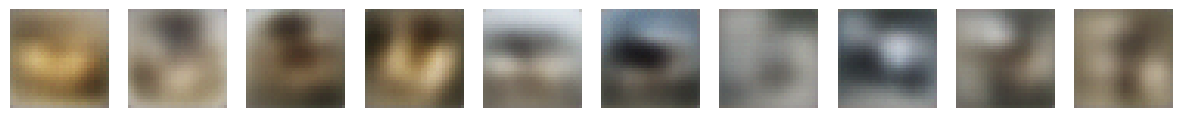

In [68]:
# Training FC-VAE
print("Training FC-VAE...")
for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader, optimizer_fcvae, epoch, num_epochs, 'fcvae', device, beta)
    if epoch % 10 == 0:
        print("Generating FC-VAE samples...")
        generate_images(fcvae, device=device)

# Training Conv-VAE
print("\nTraining Conv-VAE...")
for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader, optimizer_cvae, epoch, num_epochs, 'cvae', device, beta)
    if epoch % 10 == 0:
        print("Generating Conv-VAE samples...")
        generate_images(cvae, device=device)

# Save models
torch.save(fcvae.state_dict(), 'fcvae_cifar10.pth')
torch.save(cvae.state_dict(), 'cvae_cifar10.pth')

### Results: Model Performance and Generated Samples
- **FC-VAE Training:**  
  The FC-VAE model starts with an average loss of 2046.9977 in the first epoch, which gradually decreases to 1903.8862 by the tenth epoch. While the loss reduction indicates learning progress, the generated samples appear blurry and lack clear features, suggesting that the fully connected architecture struggles with capturing the spatial structure of images.

- **Conv-VAE Training:**  
  The Conv-VAE model demonstrates a more consistent decrease in loss, starting at 2041.4744 and reducing to 1833.0208 by the tenth epoch. The generated samples from the Conv-VAE show improved clarity compared to the FC-VAE, with more discernible shapes and features. This highlights the advantage of convolutional layers in preserving spatial hierarchies in image data, leading to better reconstruction quality.

Overall, the Conv-VAE outperforms the FC-VAE in both loss reduction and image generation quality, confirming the effectiveness of convolutional architectures for image-based tasks.

## Task 2: Latent Space Interpolation  
Using the trained VAE models, interpolation is performed between two images in the latent space to generate intermediate images. This process demonstrates how smoothly the model can transition between different data points, showcasing the learned structure of the latent space. The interpolated images are visualized in a grid format, allowing observation of gradual transformations from one image to another. The Conv-VAE architecture, with its convolutional layers for encoding and transposed convolutions for decoding, is particularly effective in maintaining spatial consistency during these transitions.

### Loading Saved Models and Preparing for Interpolation  
In this step, the previously trained Fully Connected VAE (FC-VAE) and Convolutional VAE (Conv-VAE) models are loaded to perform interpolation tasks in the latent space. The models are initialized with a latent dimension of 128 and moved to the appropriate device (GPU if available, otherwise CPU). The saved model weights (`fcvae_cifar10.pth` and `cvae_cifar10.pth`) are loaded to restore the trained parameters, and both models are set to evaluation mode to disable gradient computations during inference.

In [69]:
# Load the saved models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your FCVAE and ConvVAE classes here - you already have these defined
fcvae = FCVAE(latent_dim=128).to(device)
cvae = ConvVAE(latent_dim=128).to(device)

# Load the saved weights
fcvae.load_state_dict(torch.load('fcvae_cifar10.pth'))
cvae.load_state_dict(torch.load('cvae_cifar10.pth'))

# Set models to evaluation mode
fcvae.eval()
cvae.eval()

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=128, bias=True)
  (decoder_input): Linear(in_features=128, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(256, 2, 2))
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2,

### Selecting Distinct Images for Interpolation  
This step defines a function to identify two distinct images from the dataset for interpolation in the latent space. The function iterates through batches of images from the `test_loader`, collecting a specified number of samples (`num_tries`). These images are passed through the VAE encoder to obtain their latent space representations. The function calculates the distance between each pair of latent vectors using the Euclidean norm and selects the pair with the greatest distance, indicating they are the most distinct in the latent space. This distinct pair is returned for interpolation, allowing for a clear demonstration of the model's ability to transition smoothly between two different data points.


In [70]:
# Create a function to find images to interpolate between
def get_distinct_images(test_loader, model, device, num_tries=100):
    """
    Find two images that are relatively distinct in latent space
    """
    model.eval()
    max_distance = 0
    best_pair = None
    
    # Get a batch of images to compare
    images = []
    for i, (img, _) in enumerate(test_loader):
        if i >= num_tries:
            break
        images.append(img)
    
    images = torch.cat(images, 0).to(device)
    
    with torch.no_grad():
        # Get latent representations
        if isinstance(model, FCVAE):
            z, _ = model.encode(images.view(images.size(0), -1))
        else:
            z, _ = model.encode(images)
        
        # Find the most distinct pair
        for i in range(len(z)):
            for j in range(i + 1, len(z)):
                distance = torch.norm(z[i] - z[j])
                if distance > max_distance:
                    max_distance = distance
                    best_pair = (images[i:i+1], images[j:j+1])
    
    return best_pair

### Improved Interpolation Function  
This step defines an improved interpolation function that generates smooth transitions between two images in the latent space. The function first encodes both images to obtain their latent representations. Instead of using linear interpolation, it applies **spherical linear interpolation (slerp)**, which better handles the geometry of the latent space, resulting in more natural transitions. For each interpolation step, the interpolated latent vector is decoded back into an image, and all intermediate images are collected and returned as a stack.


In [71]:
# Improved interpolation function
def improved_interpolate_latent_space(model, img1, img2, num_steps=10):
    """
    Improved interpolation with better handling of the latent space
    """
    model.eval()
    with torch.no_grad():
        # Get latent representations
        if isinstance(model, FCVAE):
            mu1, logvar1 = model.encode(img1.view(img1.size(0), -1))
            mu2, logvar2 = model.encode(img2.view(img2.size(0), -1))
        else:
            mu1, logvar1 = model.encode(img1)
            mu2, logvar2 = model.encode(img2)
        
        # Use spherical interpolation (slerp) instead of linear
        def slerp(val, low, high):
            omega = torch.arccos((low * high).sum() / (torch.norm(low) * torch.norm(high)))
            so = torch.sin(omega)
            return torch.sin((1.0 - val) * omega) / so * low + torch.sin(val * omega) / so * high
        
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            # Interpolate in the latent space
            z = slerp(alpha, mu1, mu2)
            # Decode
            decoded_img = model.decode(z)
            interpolated_images.append(decoded_img)
            
        return torch.stack(interpolated_images)

### Plotting the Interpolated Images  
This step visualizes the interpolated images by plotting them in a row. The function processes the generated images, ensuring they are within the valid pixel range, and displays them using Matplotlib. The images are arranged side by side, providing a clear view of how the model transitions between the two original images. This helps in observing the effectiveness of the interpolation in capturing smooth and coherent transformations.

In [72]:
import numpy as np  # Add this import if not already present

def interpolate_latent_space(model, image1, image2, steps=10, device="cuda"):
    """
    Interpolate between two images in the latent space
    """
    model.eval()
    with torch.no_grad():
        # Encode both images
        mu1, logvar1 = model.encode(image1.unsqueeze(0).to(device))
        mu2, logvar2 = model.encode(image2.unsqueeze(0).to(device))
        
        # Create interpolation points
        alphas = torch.linspace(0, 1, steps)
        interpolated_images = []
        
        # Generate images at each interpolation point
        for alpha in alphas:
            mu_interp = mu1 * (1 - alpha) + mu2 * alpha
            decoded_image = model.decode(mu_interp)
            interpolated_images.append(decoded_image)
            
        return interpolated_images

def plot_interpolation(images, title="Interpolation Results"):
    """
    Plot the interpolated images in a row
    """
    # Convert list of tensors to a list of numpy arrays
    images_np = []
    for img in images:
        # Ensure the image is on CPU and in the right format
        img_np = img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        images_np.append(img_np)
    
    # Create the plot
    fig, axes = plt.subplots(1, len(images_np), figsize=(15, 2))
    plt.suptitle(title)
    
    for i, img in enumerate(images_np):
        axes[i].imshow(img)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def demonstrate_interpolation(model, train_loader, device, num_steps=10):
    # Get two random images from the dataset
    dataiter = iter(train_loader)
    images, _ = next(dataiter)
    img1, img2 = images[0], images[1]
    
    # Generate and plot interpolation
    interpolated = interpolate_latent_space(model, img1, img2, steps=num_steps, device=device)
    plot_interpolation(interpolated, title="Latent Space Interpolation")

Comparing VAE interpolations on real images...


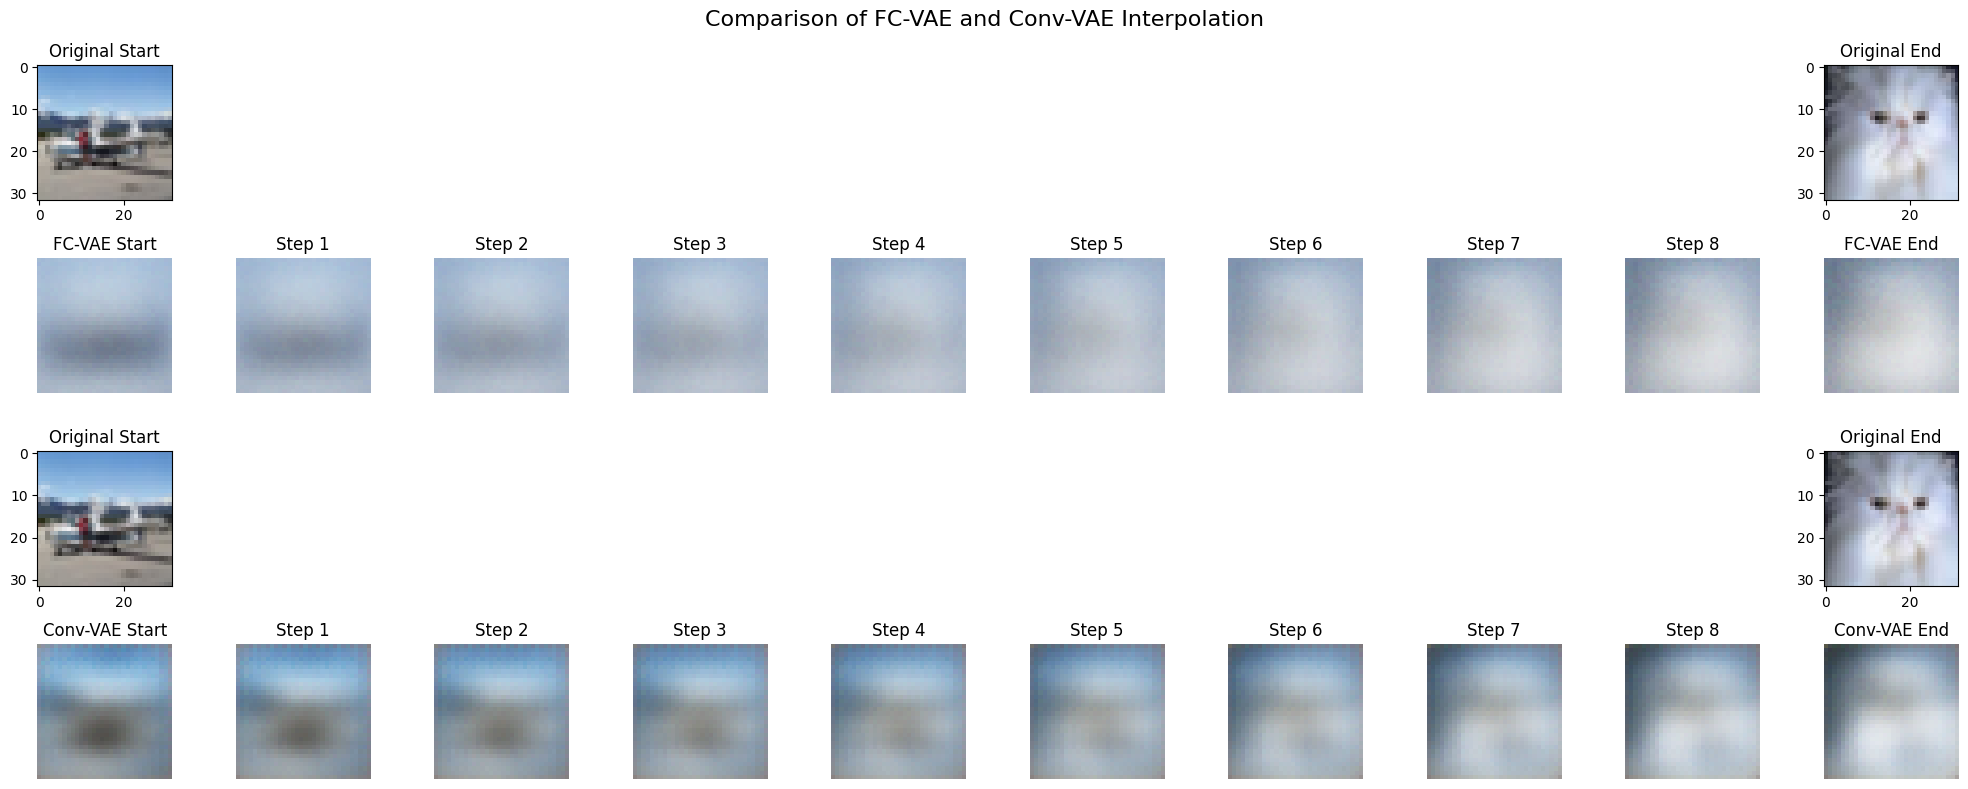


Comparing VAE interpolations with random latent vectors...


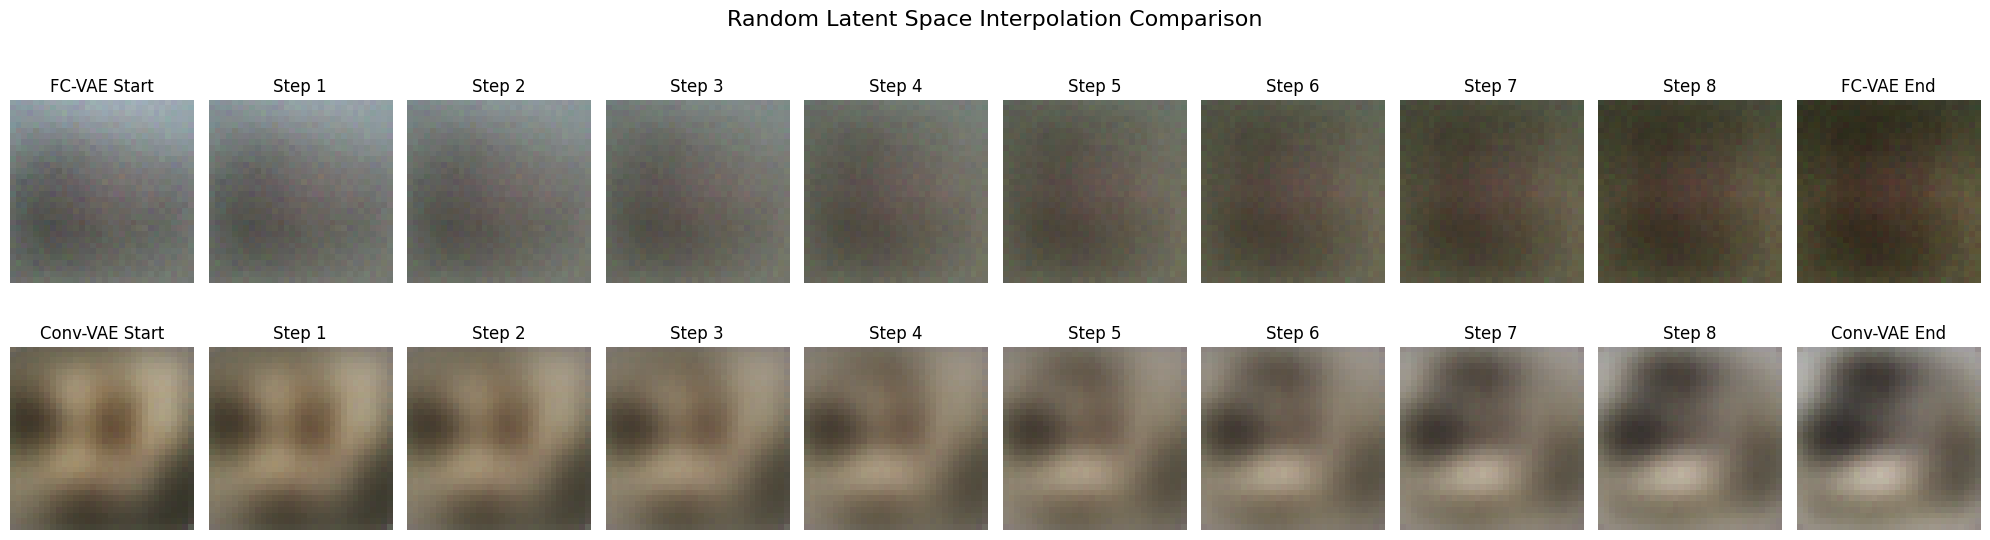

In [76]:
def interpolate_points(p1, p2, n_steps=10):
    """Linear interpolation between two points in latent space"""
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = []
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return torch.stack(vectors)

def get_random_batch_images(dataloader, num_images=2):
    """Get random images from dataloader"""
    dataiter = iter(dataloader)
    images, _ = next(dataiter)
    return images[:num_images]

def compare_vae_interpolation(fcvae, cvae, train_loader, n_steps=10):
    """Compare interpolation between FC-VAE and Conv-VAE side by side"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fcvae = fcvae.to(device)
    cvae = cvae.to(device)
    
    fcvae.eval()
    cvae.eval()
    
    with torch.no_grad():
        # Get same pair of images for both models
        images = get_random_batch_images(train_loader, 2)
        img1, img2 = images.to(device)
        
        # FC-VAE interpolation
        fc_mu1, fc_logvar1 = fcvae.encode(img1.view(1, -1))
        fc_mu2, fc_logvar2 = fcvae.encode(img2.view(1, -1))
        fc_z = interpolate_points(fc_mu1.squeeze(), fc_mu2.squeeze(), n_steps)
        fc_interpolated = fcvae.decode(fc_z.to(device))
        
        # Conv-VAE interpolation
        conv_mu1, conv_logvar1 = cvae.encode(img1.unsqueeze(0))
        conv_mu2, conv_logvar2 = cvae.encode(img2.unsqueeze(0))
        conv_z = interpolate_points(conv_mu1.squeeze(), conv_mu2.squeeze(), n_steps)
        conv_interpolated = cvae.decode(conv_z.to(device))
        
        # Create visualization
        fig, axes = plt.subplots(4, n_steps, figsize=(20, 8))
        plt.suptitle('Comparison of FC-VAE and Conv-VAE Interpolation', size=16)
        
        # Original images for FC-VAE
        axes[0][0].imshow(img1.cpu().permute(1, 2, 0).clip(0, 1))
        axes[0][-1].imshow(img2.cpu().permute(1, 2, 0).clip(0, 1))
        axes[0][0].set_title('Original Start')
        axes[0][-1].set_title('Original End')
        
        # FC-VAE interpolation
        for i in range(n_steps):
            if 0 < i < n_steps-1:
                axes[0][i].axis('off')
            img = fc_interpolated[i].cpu().permute(1, 2, 0).clip(0, 1)
            axes[1][i].imshow(img)
            axes[1][i].axis('off')
            if i == 0:
                axes[1][i].set_title('FC-VAE Start')
            elif i == n_steps-1:
                axes[1][i].set_title('FC-VAE End')
            else:
                axes[1][i].set_title(f'Step {i}')
        
        # Original images for Conv-VAE (same as FC-VAE)
        axes[2][0].imshow(img1.cpu().permute(1, 2, 0).clip(0, 1))
        axes[2][-1].imshow(img2.cpu().permute(1, 2, 0).clip(0, 1))
        axes[2][0].set_title('Original Start')
        axes[2][-1].set_title('Original End')
        
        # Conv-VAE interpolation
        for i in range(n_steps):
            if 0 < i < n_steps-1:
                axes[2][i].axis('off')
            img = conv_interpolated[i].cpu().permute(1, 2, 0).clip(0, 1)
            axes[3][i].imshow(img)
            axes[3][i].axis('off')
            if i == 0:
                axes[3][i].set_title('Conv-VAE Start')
            elif i == n_steps-1:
                axes[3][i].set_title('Conv-VAE End')
            else:
                axes[3][i].set_title(f'Step {i}')
        
        plt.tight_layout()
        plt.show()

def compare_random_interpolation(fcvae, cvae, n_steps=10):
    """Compare random interpolation between FC-VAE and Conv-VAE"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fcvae = fcvae.to(device)
    cvae = cvae.to(device)
    
    fcvae.eval()
    cvae.eval()
    
    with torch.no_grad():
        # Generate random latent vectors
        z1 = torch.randn(1, fcvae.latent_dim).to(device)
        z2 = torch.randn(1, fcvae.latent_dim).to(device)
        
        # Create interpolations
        z = interpolate_points(z1.squeeze(), z2.squeeze(), n_steps)
        z = z.to(device)
        
        # Generate images
        fc_interpolated = fcvae.decode(z)
        conv_interpolated = cvae.decode(z)
        
        # Display results
        fig, axes = plt.subplots(2, n_steps, figsize=(20, 6))
        plt.suptitle('Random Latent Space Interpolation Comparison', size=16)
        
        # FC-VAE interpolation
        for i in range(n_steps):
            img = fc_interpolated[i].cpu().permute(1, 2, 0).clip(0, 1)
            axes[0][i].imshow(img)
            axes[0][i].axis('off')
            if i == 0:
                axes[0][i].set_title('FC-VAE Start')
            elif i == n_steps-1:
                axes[0][i].set_title('FC-VAE End')
            else:
                axes[0][i].set_title(f'Step {i}')
        
        # Conv-VAE interpolation
        for i in range(n_steps):
            img = conv_interpolated[i].cpu().permute(1, 2, 0).clip(0, 1)
            axes[1][i].imshow(img)
            axes[1][i].axis('off')
            if i == 0:
                axes[1][i].set_title('Conv-VAE Start')
            elif i == n_steps-1:
                axes[1][i].set_title('Conv-VAE End')
            else:
                axes[1][i].set_title(f'Step {i}')
        
        plt.tight_layout()
        plt.show()

def main():
    # Example usage after training models
    print("Comparing VAE interpolations on real images...")
    compare_vae_interpolation(fcvae, cvae, train_loader, n_steps=10)
    
    print("\nComparing VAE interpolations with random latent vectors...")
    compare_random_interpolation(fcvae, cvae, n_steps=10)

if __name__ == "__main__":
    main()

## Task 3: Training the VAE on the JellyFish Dataset and Exploring Latent Space  
In this task, the Variational Autoencoder (VAE) will be trained on the JellyFish dataset to learn the underlying structure of the images. After training, the model will be used to generate new samples by decoding points from the latent space. To understand how the VAE represents different features of jellyfish images, sampling from various regions of the latent space will be performed. This involves selecting latent vectors from both typical regions (close to the mean) and more unusual or extreme regions (farther from the mean). The generated outputs will be visualized to analyze how changes in the latent vectors affect the appearance of the jellyfish, such as variations in shape, color, and texture. This exploration helps in understanding how well the VAE captures the diversity and characteristics of the dataset.


In [32]:
from torchvision.datasets import ImageFolder

In [29]:
pip install gdown

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached beautifulsoup4-4.13.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl.metadata (13 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
Using cached beautifulsoup4-4.13.0-py3-none-any.whl (184 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)
Using cached soupsieve-2.6-py3-none-any.whl (36 kB)
Using cached urllib3-2.3.0-py3-none-any.whl (128 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Define the FCVAE class
class FCVAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=400, latent_dim=128):
        super(FCVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z):
        return self.decoder(z).view(-1, 3, 64, 64)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [27]:
# Define the ConvVAE class
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # [batch, 128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # [batch, 256, 4, 4]
            nn.ReLU(),
            nn.Flatten()  # [batch, 256 * 4 * 4]
        )

        # Latent space
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [batch, 128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),     # [batch, 3, 64, 64]
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [28]:
# Define loss function
def loss_function(recon_x, x, mu, logvar, model_type='cvae', beta=1.0):
    if model_type == 'fcvae':
        x = x.view(x.size(0), -1)
        recon_x = recon_x.view(x.size(0), -1)

    # Ensure values are in [0, 1]
    x = torch.clamp(x, 0, 1)
    recon_x = torch.clamp(recon_x, 0, 1)

    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

In [29]:
def train(model, train_loader, optimizer, epoch, num_epochs, model_type, device, beta=1.0):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    num_batches = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        total_loss, recon_loss, kld_loss = loss_function(
            recon_batch, data, mu, logvar, model_type, beta)

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss_total += total_loss.item()
        recon_loss_total += recon_loss.item()
        kld_loss_total += kld_loss.item()
        num_batches += 1

        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}: [{batch_idx}/{len(train_loader)}]',
                  f'Loss: {total_loss.item()/len(data):.4f}')

    avg_total_loss = train_loss_total / len(train_loader.dataset)
    avg_recon_loss = recon_loss_total / len(train_loader.dataset)
    avg_kld_loss = kld_loss_total / len(train_loader.dataset)
    
    print(f'Epoch {epoch}/{num_epochs}:')
    print(f'Average Total Loss: {avg_total_loss:.4f}')
    print(f'Average Reconstruction Loss: {avg_recon_loss:.4f}')
    print(f'Average KLD Loss: {avg_kld_loss:.4f}')
    
    return avg_total_loss, avg_recon_loss, avg_kld_loss

In [33]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create dataset
data_dir = './data/jellyfish'  # Adjust path as needed
jellyfish_dataset = ImageFolder(
    root=data_dir,
    transform=transform
)

# Create dataloader
batch_size = 32
jellyfish_loader = DataLoader(
    jellyfish_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

print(f"Total number of images: {len(jellyfish_dataset)}")
print(f"Classes: {jellyfish_dataset.classes}")

Total number of images: 1879
Classes: ['Moon_jellyfish', 'Train_Test_Valid', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


In [34]:
# Sampling and visualization functions
def sample_latent_space(model, num_samples=16, sampling_type='random', scale=1.0):
    model.eval()
    with torch.no_grad():
        if sampling_type == 'random':
            z = torch.randn(num_samples, model.latent_dim).to(device) * scale
        elif sampling_type == 'class_transition':
            z1 = torch.randn(1, model.latent_dim).to(device)
            z2 = torch.randn(1, model.latent_dim).to(device)
            alphas = torch.linspace(0, 1, num_samples).view(-1, 1).to(device)
            z = z1 * alphas + z2 * (1 - alphas)
            z = z * scale
        elif sampling_type == 'structured':
            base = torch.randn(1, model.latent_dim).to(device)
            z = base.repeat(num_samples, 1)
            variations = torch.randn(num_samples, model.latent_dim).to(device) * 0.3
            z = (z + variations) * scale
        
        samples = model.decode(z)
        return samples

def visualize_samples(samples, title="Generated Jellyfish"):
    num_samples = len(samples)
    rows = int(np.sqrt(num_samples))
    cols = int(np.ceil(num_samples / rows))
    
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        img = samples[i].cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.suptitle(title, size=16)
    plt.tight_layout()
    plt.show()

Starting training...

Training FC-VAE...

FC-VAE - Epoch 1/15
Epoch 1: [0/59] Loss: 8535.3916
Epoch 1: [10/59] Loss: 8460.1084
Epoch 1: [20/59] Loss: 8371.2822
Epoch 1: [30/59] Loss: 8151.3071
Epoch 1: [40/59] Loss: 7741.8384
Epoch 1: [50/59] Loss: 7565.3696
Epoch 1/15:
Average Total Loss: 8131.6605
Average Reconstruction Loss: 8116.7637
Average KLD Loss: 14.8968

FC-VAE - Epoch 2/15
Epoch 2: [0/59] Loss: 7238.7031
Epoch 2: [10/59] Loss: 7158.0063
Epoch 2: [20/59] Loss: 7081.0400
Epoch 2: [30/59] Loss: 7107.5688
Epoch 2: [40/59] Loss: 7256.4546
Epoch 2: [50/59] Loss: 6664.2124
Epoch 2/15:
Average Total Loss: 7279.5380
Average Reconstruction Loss: 7244.3940
Average KLD Loss: 35.1440

FC-VAE - Epoch 3/15
Epoch 3: [0/59] Loss: 6951.0596
Epoch 3: [10/59] Loss: 7117.7139
Epoch 3: [20/59] Loss: 7035.4282
Epoch 3: [30/59] Loss: 6693.9521
Epoch 3: [40/59] Loss: 6668.0396
Epoch 3: [50/59] Loss: 7290.3120
Epoch 3/15:
Average Total Loss: 7131.4726
Average Reconstruction Loss: 7107.7184
Average KL

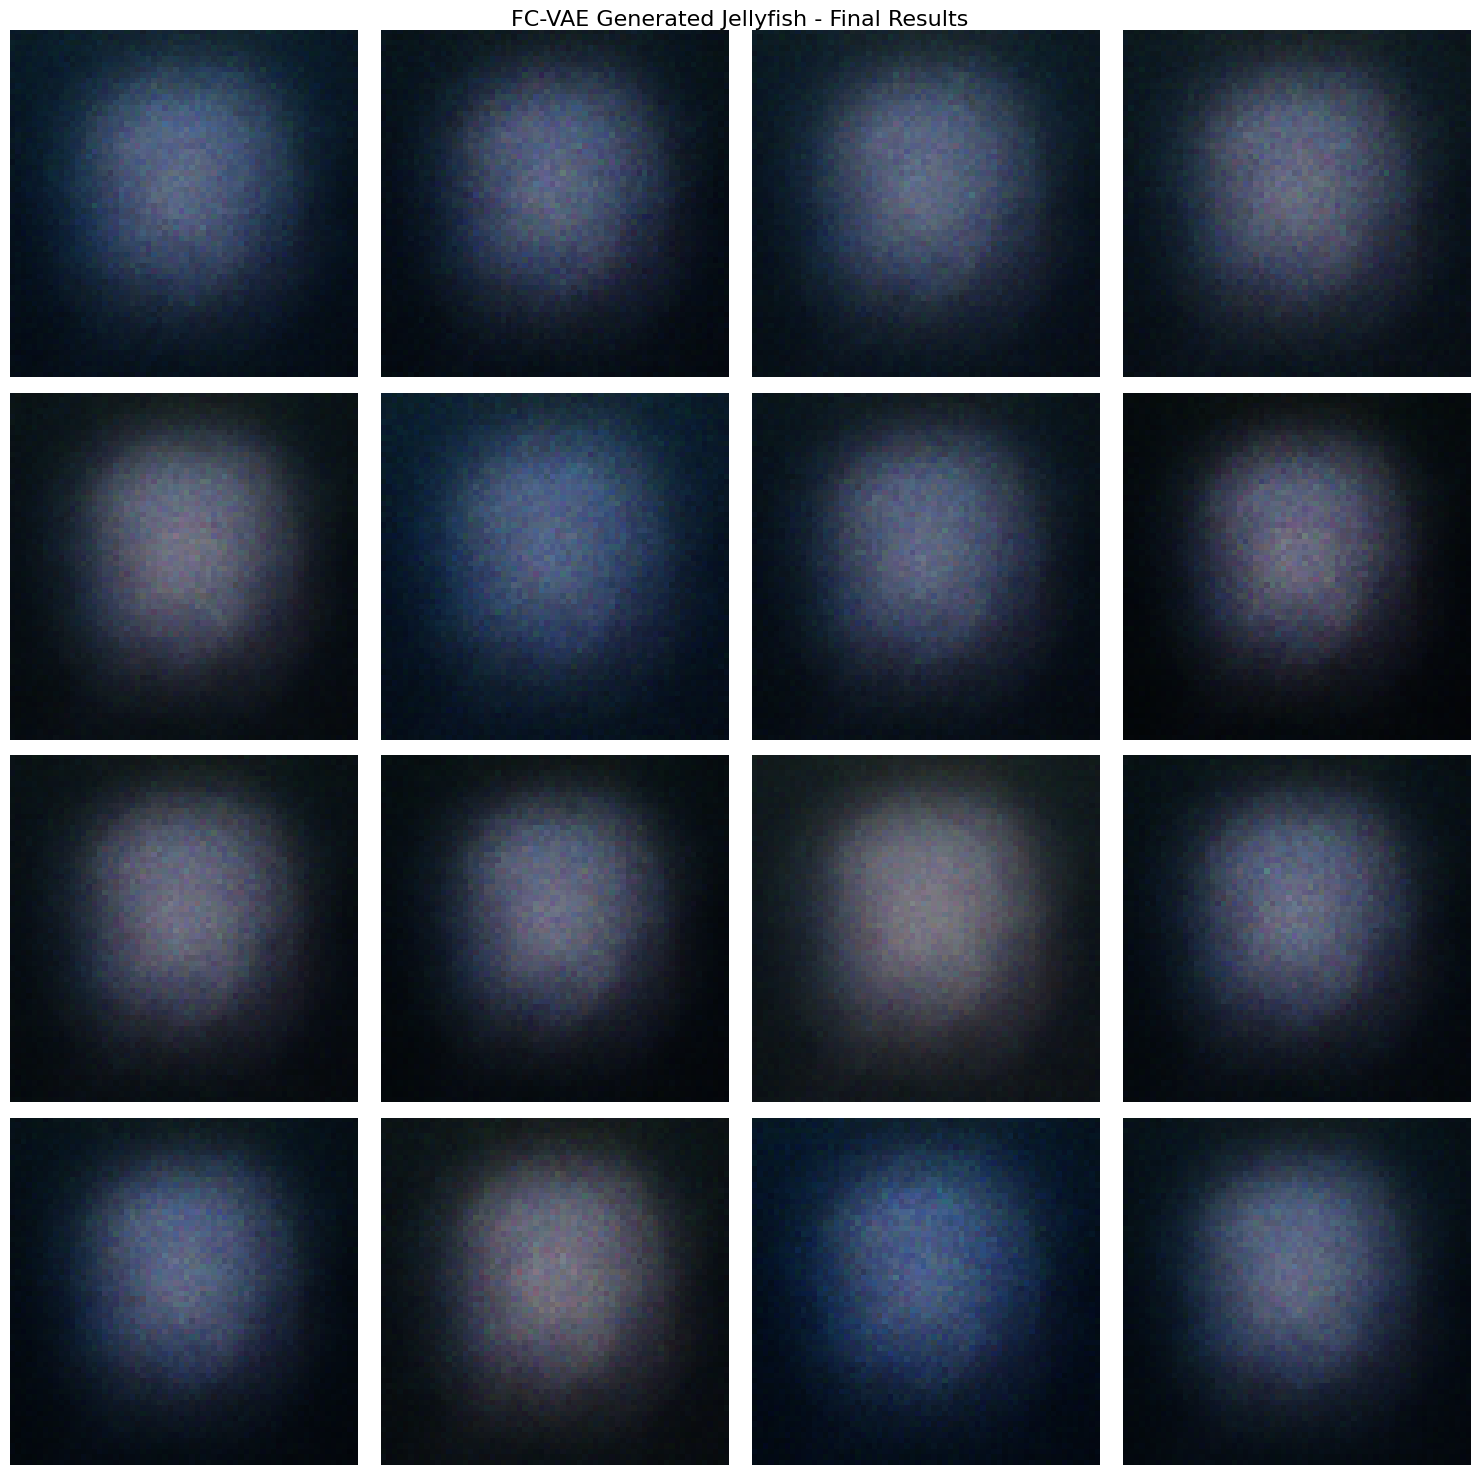


Training Conv-VAE...

Conv-VAE - Epoch 1/15
Epoch 1: [0/59] Loss: 8602.9189
Epoch 1: [10/59] Loss: 8500.5693
Epoch 1: [20/59] Loss: 8557.4092
Epoch 1: [30/59] Loss: 8476.2314
Epoch 1: [40/59] Loss: 8249.1826
Epoch 1: [50/59] Loss: 7744.2642
Epoch 1/15:
Average Total Loss: 8276.7690
Average Reconstruction Loss: 8251.6582
Average KLD Loss: 25.1108

Conv-VAE - Epoch 2/15
Epoch 2: [0/59] Loss: 7612.5327
Epoch 2: [10/59] Loss: 7578.5566
Epoch 2: [20/59] Loss: 7080.9922
Epoch 2: [30/59] Loss: 6952.2646
Epoch 2: [40/59] Loss: 7398.3628
Epoch 2: [50/59] Loss: 6329.8262
Epoch 2/15:
Average Total Loss: 7155.9700
Average Reconstruction Loss: 7111.7285
Average KLD Loss: 44.2415

Conv-VAE - Epoch 3/15
Epoch 3: [0/59] Loss: 6833.2661
Epoch 3: [10/59] Loss: 6798.6572
Epoch 3: [20/59] Loss: 6886.2305
Epoch 3: [30/59] Loss: 6852.0796
Epoch 3: [40/59] Loss: 6733.4014
Epoch 3: [50/59] Loss: 7121.5957
Epoch 3/15:
Average Total Loss: 6879.2278
Average Reconstruction Loss: 6834.9849
Average KLD Loss: 44.24

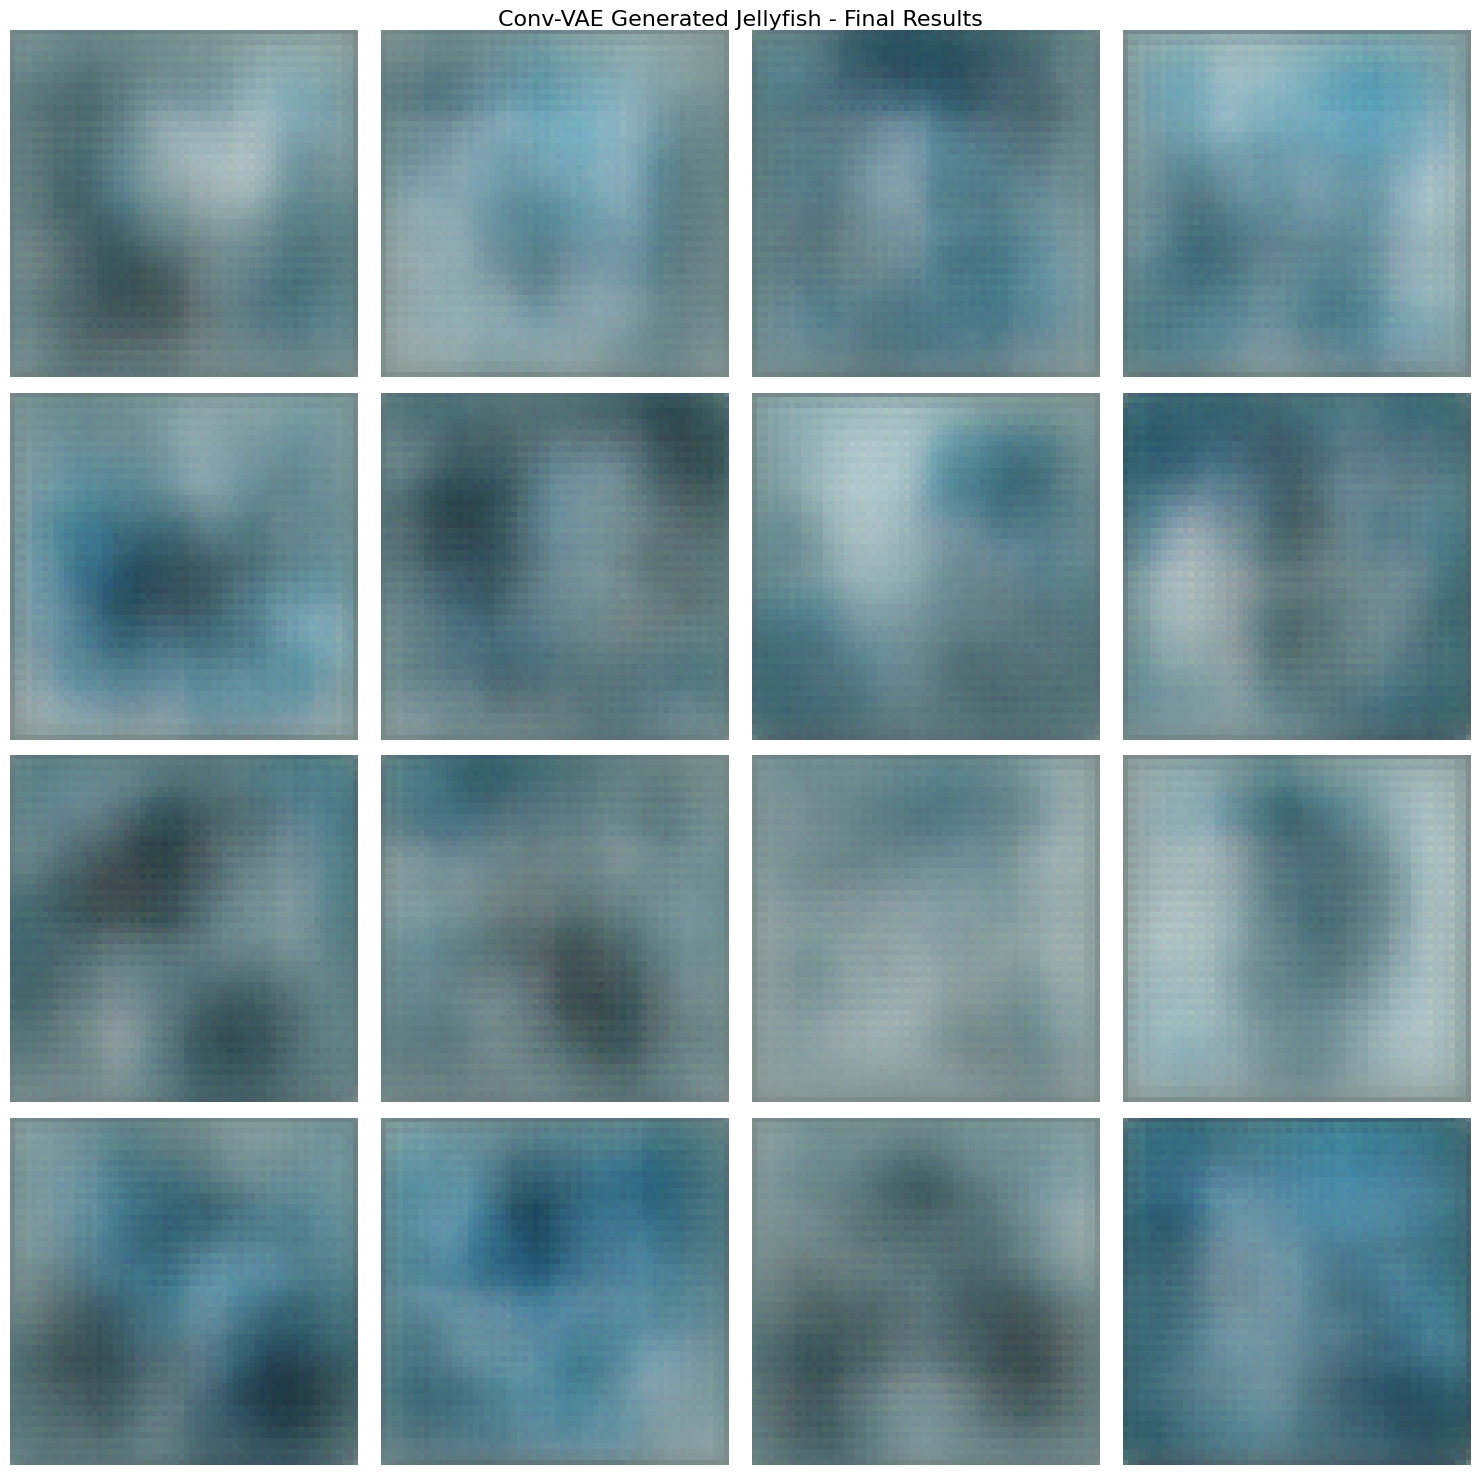

In [36]:
# Initialize and train both models
fcvae = FCVAE(input_dim=64*64*3, hidden_dim=400, latent_dim=128).to(device)
cvae = ConvVAE(latent_dim=128).to(device)

# Optimizers
optimizer_fc = optim.Adam(fcvae.parameters(), lr=1e-4)
optimizer_conv = optim.Adam(cvae.parameters(), lr=1e-4)

# Training loop
num_epochs = 15
print("Starting training...")

# Train FC-VAE for all epochs
print("\nTraining FC-VAE...")
for epoch in range(1, num_epochs + 1):
    print(f"\nFC-VAE - Epoch {epoch}/{num_epochs}")
    train(fcvae, jellyfish_loader, optimizer_fc, epoch, num_epochs, 'fcvae', device)

# Generate final FC-VAE samples
samples_fc = sample_latent_space(fcvae, num_samples=16, sampling_type='random')
visualize_samples(samples_fc, f"FC-VAE Generated Jellyfish - Final Results")

# Train Conv-VAE for all epochs
print("\nTraining Conv-VAE...")
for epoch in range(1, num_epochs + 1):
    print(f"\nConv-VAE - Epoch {epoch}/{num_epochs}")
    train(cvae, jellyfish_loader, optimizer_conv, epoch, num_epochs, 'cvae', device)

# Generate final Conv-VAE samples
samples_conv = sample_latent_space(cvae, num_samples=16, sampling_type='random')
visualize_samples(samples_conv, f"Conv-VAE Generated Jellyfish - Final Results")